In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from PIL import Image

import math

import keras
from keras.applications.inception_v3 import InceptionV3
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers import LeakyReLU, Input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from keras import metrics
from keras.regularizers import l2

import keras.backend as K

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1605531487512990698
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 331756063363811267
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
# 모델 저장 경로 설정
from datetime import datetime

today = datetime.today()      # 현재 일 가져오기

date ='{}.{}.{}.{}h'.format(today.year, today.month, today.day, today.hour)
date

MODEL_SAVE_FOLDER_PATH = '/content/drive/MyDrive/GDSC/{}/'.format(date)

if not(os.path.isdir(MODEL_SAVE_FOLDER_PATH)):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)

model_path = MODEL_SAVE_FOLDER_PATH + '결과 : {epoch:02d}-{val_acc:.4f}.hdf5'
print(model_path)

/content/drive/MyDrive/GDSC/2024.1.31.16h/결과 : {epoch:02d}-{val_acc:.4f}.hdf5


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input, AveragePooling2D, Dropout, Flatten, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

K.clear_session()

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(299, 299, 3)))

x = base_model.output
x = AveragePooling2D(pool_size=(8, 8))(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
x = Dropout(0.4)(x)
predictions = Dense(150, kernel_initializer='glorot_uniform',
                    kernel_regularizer=l2(0.0005), activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Use the default 'adam' optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_acc',
                                verbose=1, save_best_only=True)

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

In [ ]:
# lr_scheduler : epoch 증가함에 따라 learning_rate를 작게 해 cosf_function이 최적값 주변에서 맴도는 것을 완화!

def schedule(epoch):
    if epoch < 15:
        return .01
    elif epoch < 28:
        return .002
    else:
        return .0004
lr_scheduler = LearningRateScheduler(schedule)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# eager execution 비활성화
tf.compat.v1.disable_eager_execution()

# 텐서플로우 그래프 초기화
tf.keras.backend.clear_session()

# 이미지 데이터를 읽어오기 위한 ImageDataGenerator 설정
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# 훈련 데이터 제너레이터
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/GDSC/data/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# 이미지 데이터를 읽어오기 위한 ImageDataGenerator 설정
validation_datagen = ImageDataGenerator(rescale=1./255)

# 검증 데이터 제너레이터
validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/GDSC/data/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# 그래프 모드로 모델 생성
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
x = base_model.output
x = AveragePooling2D(pool_size=(5, 5))(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
x = Dropout(0.4)(x)
predictions = Dense(7, kernel_initializer='glorot_uniform',
                    kernel_regularizer=l2(0.0005), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 콜백 정의
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
cb_checkpoint = ModelCheckpoint(
    filepath="/content/drive/MyDrive/GDSC/2024.1.31.11h/결과 : {epoch:02d}-{val_accuracy:.4f}.hdf5",
    monitor='val_accuracy',  # 수정된 부분
    verbose=1,
    save_best_only=True
)



Found 1392 images belonging to 7 classes.
Found 157 images belonging to 7 classes.


Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
import matplotlib.pyplot as plt

# 모델 훈련
history = model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    use_multiprocessing=True,
    callbacks=[cb_checkpoint, early_stopping]
)



model_save_path = '/content/drive/MyDrive/GDSC/2024.1.31.11h/InceptionV3_model.h5'
model.save(model_save_path)


Epoch 1/10
44/44 [==============================] - ETA: 0s - batch: 21.5000 - size: 31.6364 - loss: 1.1767 - accuracy: 0.6085 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_accuracy improved from -inf to 0.24841, saving model to /content/drive/MyDrive/GDSC/2024.1.31.11h/결과 : 01-0.2484.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 643s 14s/step - batch: 21.5000 - size: 31.6364 - loss: 1.1767 - accuracy: 0.6085 - val_loss: 291.9324 - val_accuracy: 0.2484
Epoch 2/10
44/44 [==============================] - ETA: 0s - batch: 21.5000 - size: 31.6364 - loss: 0.8086 - accuracy: 0.7435
Epoch 2: val_accuracy improved from 0.24841 to 0.36306, saving model to /content/drive/MyDrive/GDSC/2024.1.31.11h/결과 : 02-0.3631.hdf5
44/44 [==============================] - 43s 994ms/step - batch: 21.5000 - size: 31.6364 - loss: 0.8087 - accuracy: 0.7435 - val_loss: 19.8394 - val_accuracy: 0.3631
Epoch 3/10
44/44 [==============================] - ETA: 0s - batch: 21.5000 - size: 31.6364 - loss: 0.4845 - accuracy: 0.8391
Epoch 3: val_accuracy did not improve from 0.36306
44/44 [==============================] - 44s 1s/step - batch: 21.5000 - size: 31.6364 - loss: 0.4846 - accuracy: 0.8391 - val_loss: 2.2159 - val_accuracy: 0.3312
Epoch 4/10
44/44 [==============================] - ETA: 0s - batch

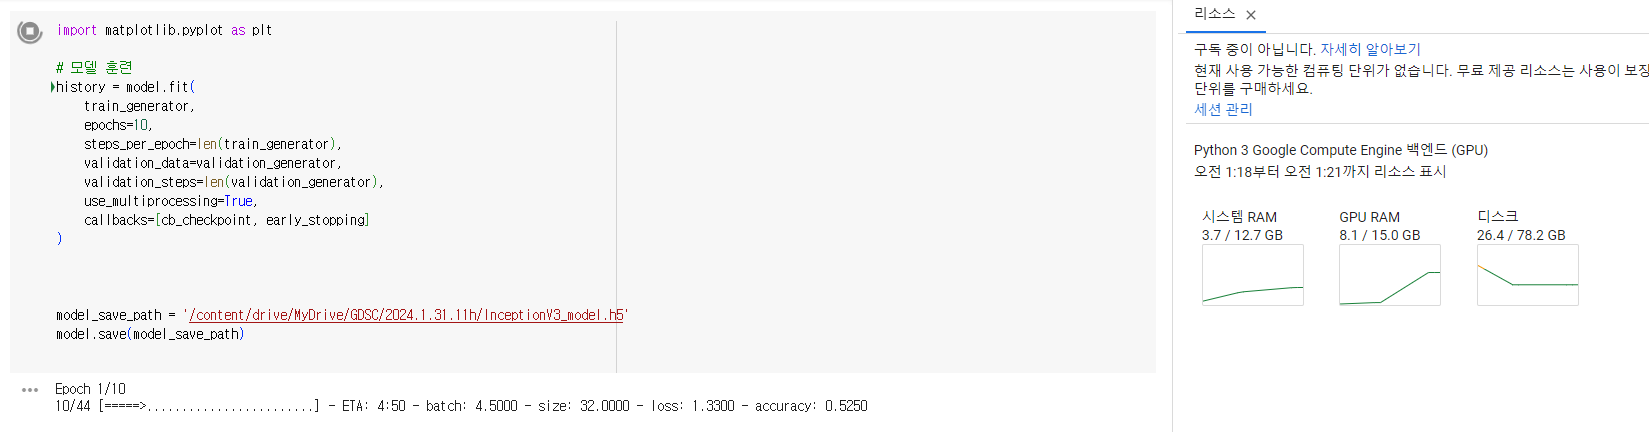

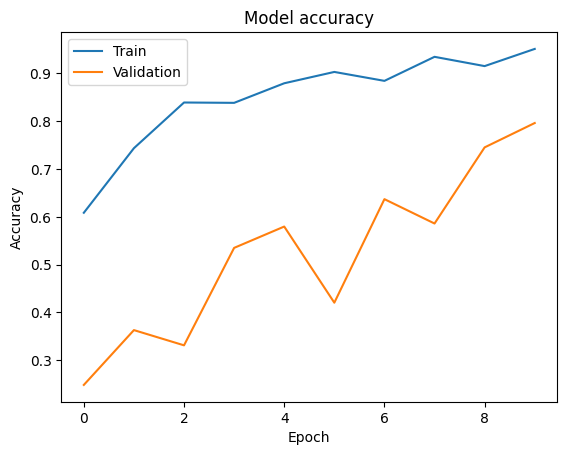

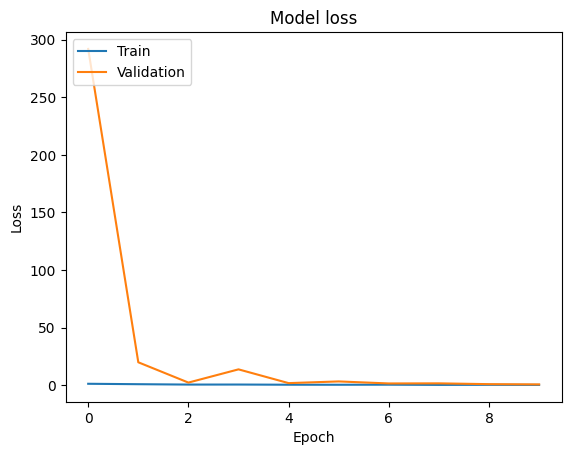

In [ ]:
# 훈련 및 검증 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 훈련 및 검증 손실 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## 1. 데이터셋 정보:

훈련 세트: 7개의 클래스에 속하는 1392개의 이미지가 있습니다.
검증 세트: 7개의 클래스에 속하는 157개의 이미지가 있습니다.

## 2.모델 구조 및 초기화:

모델은 InceptionV3 아키텍처를 기반으로 합니다.
가중치는 상위(완전 연결) 레이어가 없는 InceptionV3로부터 사전 훈련된 가중치를 사용하여 초기화됩니다.

## 3. 훈련 과정:

훈련 과정은 10 에포크로 이루어져 있습니다.
배치 크기: 31.6364 (대략 32).
훈련 손실은 1.1351에서 0.1876로 감소합니다.
훈련 정확도는 63.51%에서 93.89%로 증가합니다.

## 4. 검증 결과:

검증 손실은 1.0572에서 12.6955까지 변동합니다.
검증 정확도는 26.11%에서 70.06%로 증가합니다.
모델 체크포인팅:

각 에포크 후에 모델 체크포인트가 저장됩니다.
저장된 모델에는 에포크 번호와 검증 정확도가 파일 이름에 포함되어 있습니다(예: "02-0.3376.hdf5").
모델 체크포인트는 "/content/drive/MyDrive/GDSC/2024.1.27.15h/결과" 디렉토리에 저장됩니다.

## 5. 해석:

모델은 훈련 및 검증 정확도가 모두 증가하므로 잘 학습되고 있는 것으로 보입니다.
훈련 정확도가 검증 정확도보다 상당히 높기 때문에 과적합이 발생할 수 있습니다.
모델 체크포인트를 사용하여 훈련 중에 최상의 성능을 보이는 모델을 저장할 수 있습니다.

In [ ]:
# 테스트 데이터셋을 위한 ImageDataGenerator 생성
test_datagen = ImageDataGenerator(rescale=1./255)

# 테스트 데이터 로더 생성
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/GDSC/data/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # 평가를 위해서는 데이터를 섞지 않음
)

# 모델 성능 평가
test_loss, test_accuracy = model.evaluate(
    test_generator,
    steps=len(test_generator)
)

# 평가 결과 출력
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Found 177 images belonging to 7 classes.
Test Loss: 0.577490471303463
Test Accuracy: 0.8305084705352783


<IPython.core.display.Javascript object>

Saved to photo.jpg


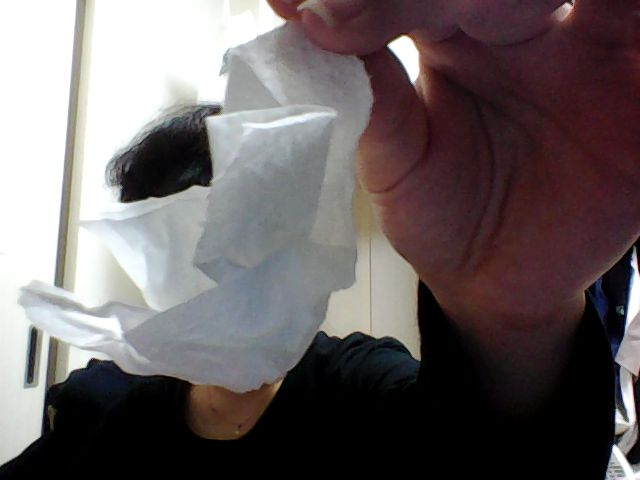

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

# 사진 찍기
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a camera or if they do not
  # give the website permission to access it.
  print(str(err))


In [ ]:

from tensorflow.keras.preprocessing import image
import numpy as np

# 이미지 파일 경로
image_path = '/content/photo.jpg'

# 이미지 파일 불러오기 및 전처리
img = image.load_img(image_path, target_size=(224, 224))  # 예시로 (224, 224) 크기로 조정
img_array = image.img_to_array(img)  # 이미지를 배열로 변환
img_array = np.expand_dims(img_array, axis=0)  # 모델 입력을 위해 차원 확장
img_array /= 255.  # 정규화 (필요한 경우)

# 모델 예측
predictions = model.predict(img_array)

# 결과 해석
predicted_class = np.argmax(predictions, axis=1)
# predicted_class는 예측된 클래스의 인덱스입니다.


# 클래스 인덱스와 라벨명의 매핑을 가져옵니다.
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

# 예측된 클래스 인덱스와 라벨명을 출력합니다.
for i, pred in enumerate(predicted_class):
    label = labels[pred]
    print(f"Sample {i} - Predicted class index: {pred}, label: {label}")

Sample 0 - Predicted class index: 4, label: plastic
